# **Movie Recommendation System**

---

## **1. Business Objective**

All entertainment websites or online stores have millions/billions of items. It becomes challenging for the customer to select the right one. At this place, recommender systems come into the picture and help the user to find the right item by minimizing the options.

Recommendation Systems in the world of machine learning have become very popular and are a huge advantage to tech giants like Netflix, Amazon and many more to target their content to a specific audience. These recommendation engines are so strong in their predictions that they can dynamically alter the state of what the user sees on their page based on the user’s interaction with the app.

The business objective for us is:
1. To create a Collaborative Filtering based Movie Recommendation System.
2. Predict the rating that a user would give to a movie that he has not yet rated.
3. Minimize the difference between predicted and actual rating (RMSE and MAPE).


## **2. Data Collection**

The dataset has been obtained from Grouplens.

Link : https://grouplens.org/datasets/movielens/20m/

This dataset (ml-20m) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files genome-scores.csv, genome-tags.csv, links.csv, movies.csv, ratings.csv and tags.csv.

For our objective, we would be using "ratings.csv" and "movies.csv" data files.

In [ ]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Setting up some parameters for the workbook

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)

In [ ]:
!pip install fuzzywuzzy
!pip install scikit-surprise

In [ ]:
from scipy import sparse

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SlopeOne
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

In [ ]:
from datetime import datetime
import os
import random
import gc

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

## **3. Data Preparation/Preprocessing**

We will start with loading and familiarizing with the dataset so that we can prepare the data for Machine Learning (ML) modelling.

In [ ]:
# Loading the dataset
movie_ratings = pd.read_csv("/content/ratings.csv")
movies = pd.read_csv("/content/movies.csv")

In [ ]:
movie_ratings.head()


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Creating a newId for every movie to reduce the range of existing movieId
#this only gives us the unique values for movies.
movies["newId"] = range(1, movies["movieId"].nunique()+1)
movies.head()
movie_ratings.isnull()

,userId,movieId,rating,timestamp
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
43573,False,False,False,False
43574,False,False,False,False
43575,False,False,False,False
43576,False,False,False,False


In [ ]:
# Converting the the UTC timestamp to Datetime
movie_ratings["timestamp"] = movie_ratings["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x).strftime("%Y-%m-%d"))

# Merging the movies and ratings data files
movie_ratings = movie_ratings.merge(movies, how="left", on="movieId")

# Renaming the timestamp to date
movie_ratings.rename(columns={"timestamp": "date"}, inplace=True)

# Updating the movieId with the newId
movie_ratings["movieId"] = movie_ratings["newId"]
movies["movieId"] = movies["newId"]

In [ ]:
# Dropping the newId from the datasets
movie_ratings.drop(["newId"], axis=1, inplace=True)
movies.drop(["newId"], axis=1, inplace=True)

# Sorting ratings based on date
movie_ratings.sort_values(by = "date", inplace = True)
movie_ratings.reset_index(drop=True, inplace=True)
#reset index basically resets the indices of the data frame and gives it a default index

In [ ]:
# Checking the features and no. of records in the dataset

print("The number of records are : ", movie_ratings.shape[0])
print("The number of features are : ", movie_ratings.shape[1])
print("The list of features is : ", movie_ratings.columns)
movie_ratings.head()

The number of records are :  43578
The number of features are :  6
The list of features is :  Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres'], dtype='object')


,userId,movieId,rating,date,title,genres
0,337,377.0,4.0,1970-01-01,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller
1,172,294.0,3.0,1996-04-23,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,172,298.0,3.0,1996-04-23,Quiz Show (1994),Drama
3,172,314.0,4.0,1996-04-23,Stargate (1994),Action|Adventure|Sci-Fi
4,172,316.0,5.0,1996-04-23,"Shawshank Redemption, The (1994)",Crime|Drama


Observations:

1. There are about 20+M records of the data.
2. There are 6 features: userId, movieId, rating, date, title and genres.

### **3.1 Data Cleaning**

We will begin with data cleaning such that we can handle missing values, outliers, rare values and drop the unnecessary features that do not carry useful information.


In [ ]:
# Checking for duplicates

print("No. of duplicates records in the dataset : ", movie_ratings.columns.duplicated().sum())

No. of duplicates records in the dataset :  0


Observations:
1. There are no duplicate records in the dataset.

In [ ]:
# Checking the columns' titles and datatypes

movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43578 entries, 0 to 43577
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   43578 non-null  int64  
 1   movieId  43366 non-null  float64
 2   rating   43578 non-null  float64
 3   date     43578 non-null  object 
 4   title    43366 non-null  object 
 5   genres   43366 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 2.0+ MB


#### **3.1.1 Handling Missing Values**

Identifying the features that have some missing values and imputing them.

In [ ]:
# Checking the number of missing values in data

movie_ratings.isna().sum()

,0
userId,0
movieId,212
rating,0
date,0
title,212
genres,212


Observations:

1. It looks like that the dataset is well maintained as we do not see any missing values, which is good.

### **3.2 Exploratory Data Analysis**

After the data cleaning steps, we can now perform EDA on the dataset to discover patterns and relationships that will help in understanding the data better.

#### **3.2.1 Univariate Analysis**

Analyzing each feature inidividually to gain insights from the data and discover any outliers.

In [ ]:
# Checking the feature "userID"

total_users = len(np.unique(movie_ratings["userId"]))
print("The count of unique userID in the dataset is : ", total_users)
print("The top 5 userID in the dataset are : \n", movie_ratings["userId"].value_counts()[:5])

The count of unique userID in the dataset is :  337
The top 5 userID in the dataset are : 
 userId
156    2179
208    1288
298    1127
116    1110
104     998
Name: count, dtype: int64


Observations:

1. "userId" are the Users that were selected at random for inclusion and their ids have been anonymized.
2. There are 138K+ unique users in the dataset.
3. userId 118205 has around 9K records in the dataset.

In [ ]:
# Checking the feature "movieID"

total_movies = len(np.unique(movie_ratings["movieId"]))
print("The count of unique movieID in the dataset is : ", total_movies)
print("The top 5 movieID in the dataset are : \n", movie_ratings["movieId"].value_counts()[:5])

The count of unique movieID in the dataset is :  5817
The top 5 movieID in the dataset are : 
 movieId
294.0      173
353.0      170
477.0      143
316.0      143
588.0      138
109.0      121
1.0        120
584.0      120
258.0      118
377.0      114
149.0      113
47.0       112
585.0      109
2773.0     109
2487.0     109
587.0      109
603.0      109
454.0      108
32.0       108
50.0       107
524.0      107
768.0      106
341.0      100
374.0      100
583.0       99
1243.0      98
1174.0      97
1172.0      97
1185.0      96
361.0       93
2874.0      92
364.0       86
1173.0      86
1529.0      85
497.0       83
844.0       82
164.0       82
314.0       82
641.0       81
592.0       81
152.0       81
1945.0      80
2677.0      80
229.0       80
725.0       79
590.0       79
1662.0      79
4898.0      78
34.0        77
5854.0      77
4212.0      76
1264.0      75
1114.0      73
4133.0      73
1213.0      72
1238.0      70
21.0        69
1076.0      69
39.0        69
326.0       

Observations:

1. "movieId" represents the movies with at least one rating or tag in the dataset.
2. There are close to 26K+ unique movies in the dataset.
3. movieId 294, 353, 316 and 588 are few popular movies which has been rated over 60K times.

In [ ]:
# Helper function to Change the numeric label in terms of Millions

def changingLabels(number):

    return str(number/10**6) + "M"

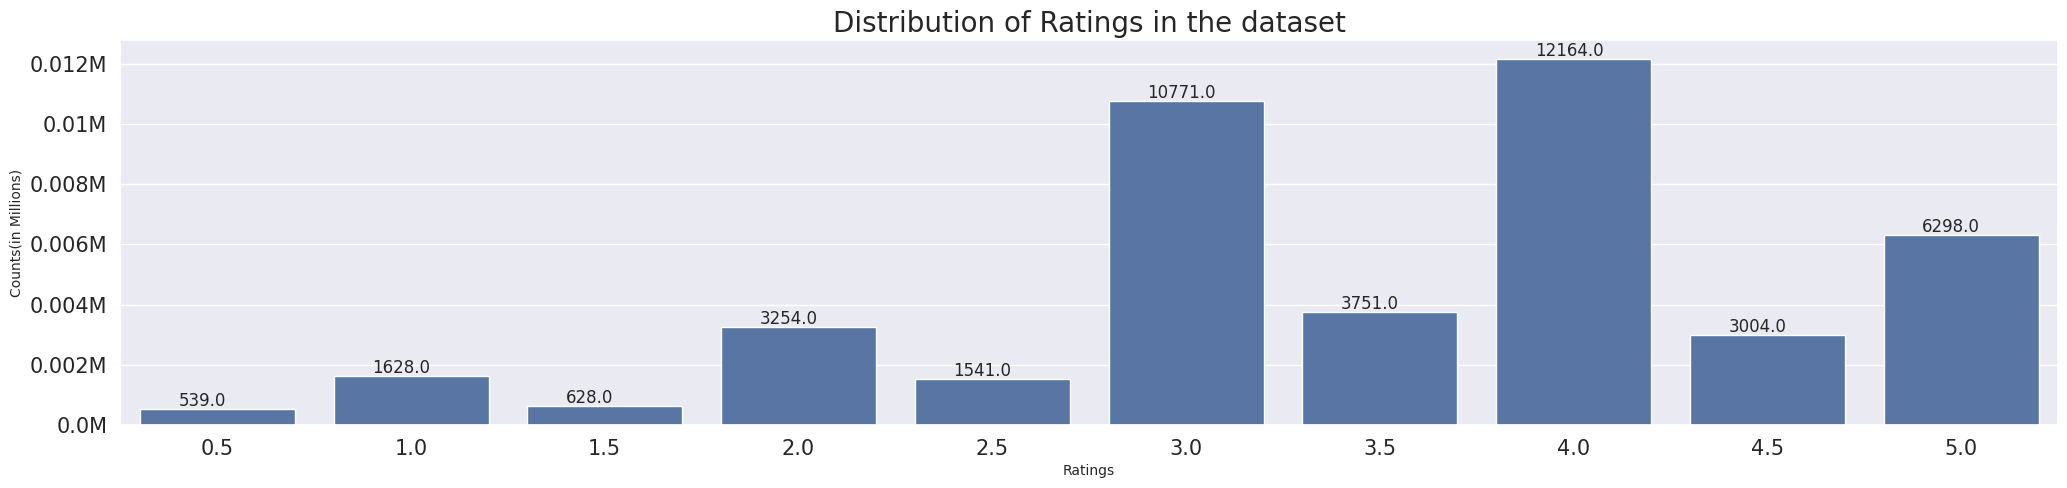

In [ ]:
# Checking the feature "rating"

sns.set(style="darkgrid")
#set the style to darkgrid with a grid

fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
# fig, axes: Creates a large plot area (canvas) where we can draw.
# figsize=(25, 5): The size of the plot is set to be wide (25 units) and not very tall (5 units).
# sharey=True: If there were more plots, they would share the same y-axis scale.

sns.countplot(x ="rating", data=movie_ratings, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
#set custom labels in the y axis
#changingLabels(num): This function, which we defined earlier, formats the y-axis labels (e.g., changing 1000000 to 1M).
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

# #loops over each bar in the plot
# p.get_height(): Gets the height (count) of the bar and displays it as text on the bar.
# (p.get_x() + 0.2, p.get_height() + 100): Positions the text slightly to the right of the bar and above its top.

plt.tick_params(labelsize = 15)
#to make numbers and labels on the x and y axes bigger for better readability

plt.title("Distribution of Ratings in the dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

Observations:

1. The ratings given by users to movies lies in between 0.5 to 5.
2. A high proportion of the movies have been rated 3, 3.5 or 4 by the users.
3. The distribution of ratings look a bit left skewed as large proportion of ratings is in between 3 to 5.

In [ ]:
# Checking the feature "date"

print("The count of unique date in the dataset is : ", movie_ratings["date"].nunique())
print("The first rating was given on : ", movie_ratings["date"].min())
print("The latest rating was given on : ", movie_ratings["date"].max())
print("The top 5 date in the dataset are : \n", movie_ratings["date"].value_counts()[:5])
#Return a Series containing counts of unique values
#The resulting object will be in descending order so that the first element is the most frequently-occurring element. Excludes NA values by default.

The count of unique date in the dataset is :  1324
The first rating was given on :  1970-01-01
The latest rating was given on :  2015-03-30
The top 5 date in the dataset are : 
 date
1999-12-11    1032
2005-11-23     744
2001-06-13     660
2000-08-03     516
1999-12-13     480
Name: count, dtype: int64


Observations:

1. There are ~7K unique dates when the ratings were given by a user to a movie.
2. The first rating was given on 1995-01-09 and the latest rating was given on 2015-03-31.
3. Around 91K+ ratings were observed on 2000-11-20.

In [ ]:
# Checking the feature "title"

movie_list = movie_ratings["title"].unique()
print("The count of unique title in the dataset is : ", movie_ratings["title"].nunique())
print("The top 5 title in the dataset are : \n", movie_ratings["title"].value_counts()[:5])

The count of unique title in the dataset is :  5815
The top 5 title in the dataset are : 
 title
Pulp Fiction (1994)                 173
Forrest Gump (1994)                 170
Shawshank Redemption, The (1994)    143
Jurassic Park (1993)                143
Silence of the Lambs, The (1991)    138
Name: count, dtype: int64


Observations:

1. There are 26K+ unique movie titles in the dataset.
2. Pulp Fiction, Forrest Gump, Shawshank Redemption and Silence of the Lambs are the top 4 movies in terms of no. of ratings received which are over 60K+ for each one.

In [ ]:
# Extract unique Genres along with their count

unique_genres = {}
#empty dictionary

def ExtractGenres(x):
    for g in x.split("|"):
      #if x is "Adventure|Action|Comedy", it splits into ["Adventure", "Action", "Comedy"]
      #go through each genre in the list
        if g not in unique_genres.keys():
          #we ll check if the genre exists as key in the unique value dictionary
            unique_genres[g] = 1
            #the first occurence of the genre
        else:
            unique_genres[g] = unique_genres[g] + 1
            #simply increment the count of the genre by one

movie_ratings["genres"].apply(ExtractGenres)
#to each value in the genres column of the movie_ratings dataset ; This goes through all the rows and extracts and counts the genres
print("Genres Extracted from the dataset.")

AttributeError: 'float' object has no attribute 'split'

In [ ]:
# Visualizing the feature "Genres"

genres_df = pd.DataFrame(list(unique_genres.items()))
#if unique_genres is {'Action': 10, 'Comedy': 7}, then unique_genres.items() will output [('Action', 10), ('Comedy', 7)]
#We convert the items of the dictionary to a list of tuples and then create a DataFrame from the list with the tuples.

genres_df.columns = ["Genre", "Count"]
#label the columns

sns.set(style="darkgrid")

fig, axes = plt.subplots(1, 1, figsize=(25, 8), sharey=True)
#1 single space for a single plot

sns.barplot(y="Count", x="Genre", data=genres_df, ax=axes)
#we've plotted a bar plot over the figure

axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
#retrieves the y-axis tick positions, applies a transformation (through changingLabels) to each tick(y label), and then sets those transformed values as the new y-axis labels

for p in axes.patches:
  #for each bar in the plot
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))
    #gets the integer value of the height of each bar and positions it to the center and a little higher than the plot itself

plt.tick_params(labelsize = 15)
#size of the text displayed

plt.title("Distribution of Genres in the dataset", fontsize = 20)
plt.xlabel("Genres", fontsize = 15)
plt.xticks(rotation=60, fontsize=10)
#roatates the value on the x label
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

Observations:

1. There are 19 different genres of movies while there are few whose genre has not been mentioned.
2. Drama, Comedy, Action and Thriller are top 4 genres of movies present in the dataset.

In [ ]:
movie_ratings.head()

#### **3.2.2 Train & test Splitting**

Splitting the data into train and test sets before proceeding towards further EDA and Feature Engineering.

In [ ]:
import os

# Define the local file path where data will be saved
file_path = "/content"  # This is the default working directory in Colab

# Check and create TrainData if it doesn't exist
if not os.path.isfile(file_path + "/TrainData.pkl"):
    print("Creating Train Data and saving it..")
    movie_ratings.iloc[:int(movie_ratings.shape[0] * 0.80)].to_pickle(file_path + "/TrainData.pkl")
    #This line selects the first 80% of the data from the movie_ratings DataFrame for the training set.
    # movie_ratings.shape[0] * 0.80 gives the number of rows that represent 80% of the dataset.
    # iloc[:int(...)] selects the rows from index 0 up to 80% of the dataset.
    #shape fetches the number of rows here
    # 80% of the data is used for training
    # 20% of the data is used for testing

    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop=True, inplace=True)
else:
    print("Loading Train Data..")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop=True, inplace=True)

# Check and create TestData if it doesn't exist
if not os.path.isfile(file_path + "/TestData.pkl"):
    print("Creating Test Data and saving it..")
    movie_ratings.iloc[int(movie_ratings.shape[0] * 0.80):].to_pickle(file_path + "/TestData.pkl")
    #int(movie_ratings.shape[0] * 0.80) calculates the index from where to start the test data (80% of the dataset).
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop=True, inplace=True)
else:
    print("Loading Test Data..")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop=True, inplace=True)


In [ ]:
Train_Data.head()

In [ ]:
# Creating list of unique movies from Train Set

movie_list_in_training = Train_Data.drop_duplicates(subset=["title"], keep="first")[["movieId", "title", "genres"]]
#keeps the first occurence of that "title" from the title column
#After removing duplicates, this selects the relevant columns (movieId, title, and genres) from the dataset.
#This will help in having only essential information for each movie: the movieId, the title, and the genres

movie_list_in_training = movie_list_in_training.reset_index(drop=True)
#reset the indices to default
movie_list_in_training.head()

In [ ]:
# Checking the basic statistics for the training data

print("Total Train Data..")
print("Total number of movie ratings in train data : ", str(Train_Data.shape[0]))
print("Number of unique users in train data : ", str(len(np.unique(Train_Data["userId"]))))
print("Number of unique movies in train data : ", str(len(np.unique(Train_Data["movieId"]))))

#### **3.2.3 Bi-variate Analysis**

Analyzing multiple features together to discover relations, correlations and patterns.  

---

#####**1. Analyzing the Distribution of Ratings**

In [ ]:
# Checking basic statistics for "rating"

print("The basic statistics for the feature is : \n", Train_Data["rating"].describe())

In [ ]:
# Visualizing the "rating" for the train set

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
#drawing space for a single plot, with fig width and height, cna draw multiple plots on the same space

sns.countplot(x="rating", data=Train_Data, ax=axes)
#rating countplot
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
#custom labels for the y axis, by converting the large numerical values into value+million

for p in axes.patches:
  #for each bar in the barplot
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))
    #annotate or provide the height of the bars, or the y label values exact, positioned towards the center.

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in the training dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

Observations:

1. The distribution of ratings seems to be similar as before.
2. The mean and median value are very close to around 3.5.

---

#####**2. Analyzing the number of ratings with date.**

In [ ]:
# Extracting the day of week from the date when rating was provided
import pandas as pd

Train_Data["date"] = pd.to_datetime(Train_Data["date"], errors='coerce')
#This function converts the values in the "date" column to datetime objects. This is necessary because the data may have been read as strings or in an inconsistent format,
#and converting it to datetime makes it easier to work with and extract specific information like the day of the week.
#any invalid date values (e.g., improperly formatted dates), they are turned into NaT (Not a Time)

Train_Data["DayOfWeek"] = Train_Data["date"].dt.strftime('%A')
#accesses the datetime attributes of the "date" column (.dt)
#date into the full name of the day of the week and stored in the day of week column

Train_Data["Weekday"] = Train_Data["date"].apply(lambda x : 1 if x.dayofweek > 5 else 0)
#binary attribute to identify is the day of the week is a weekday(1) or a weekend(0)

In [ ]:
# Converting the number into 'Ks.
#previously we did the same for millions
def ChangingLabelsInK(number):
    return str(int(number/10**3)) + "K"

In [ ]:
# Visualizing the count of total ratings made per month

sns.set(style="darkgrid")
#similarly set the background to dark, and enable grid
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
#create a plot in a single column and row, allocate 25 spaces horizontally, and 5 vertically, allow other plots to be plotted over the same space

axes = Train_Data.resample("m", on = "date")["rating"].count().plot()
#Train_Data.resample("m", on="date"): This resamples the data by month. The argument "m" stands for monthly resampling,
#and on="date" tells the code to resample based on the "date" column.
# ["rating"].count(): After resampling the data by month, this counts the number of ratings made each month.
# .plot(): This plots the resampled data (the count of ratings per month) on the axes.

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
#this time we consider values in thousands and hence we change the y label values in terms of thousands.

axes.set_title("Count of Total Ratings per Month", fontsize = 20)
axes.set_xlabel("Date", fontsize = 15)
axes.set_ylabel("Number of Ratings (in thousands)", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.show()

# The y-axis labels represent the count of ratings over time, so these values are continuous
#line plot is used in this scenario because you're trying to visualize how the count of ratings changes over time, specifically by month
#time series

Observations:

1. The no. of ratings per month was very high in few of the months between 1996 to 1998.
2. Similarly, post the 2000s, there are few month that have few months of very high no. of ratings.
3. The count remains steady after 2001 till 2010, with a spike at few month of 2006.

In [ ]:
# Visualizing the count of ratings by weekday

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="Weekday", y="rating" , data=Train_Data.groupby(by=["Weekday"], as_index=False)["rating"].count(), ax=axes)
#we use group by to create a bar plot segragating the weekdays and weekends.
#["rating"].count(): After grouping by "Weekday", this counts how many ratings were made for each group (i.e., how many ratings occurred on weekdays and weekends).
#in totality, This gives a new dataframe where the "Weekday" column shows the group (either 0 for weekdays or 1 for weekends), and the "rating" column shows the total number of ratings for each group.

for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))
    #again this annotates the heights of the bars on the plot at specified position.

axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of number of ratings by Weekday", fontsize = 20)
plt.xlabel("Weekday", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

In [ ]:
# Visualizing the count of ratings by individual days of the week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="DayOfWeek", y="rating" , data=Train_Data.groupby(by=["DayOfWeek"], as_index=False)["rating"].count(), ax=axes)
#compare by days of the week -> get the count of the ratings and plot in a bar graph.

for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))
    #annoate the height on the specified positions on each bar.

axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
#custom y labels instead of the default labels

plt.tick_params(labelsize = 15)
plt.title("Distribution of number of ratings by individual days", fontsize = 20)
plt.xlabel("Days", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

Observations:

1. The no. of ratings does not vary too much the days of the week.
2. "Monday" and "Tuesday" clearly has more no. of ratings than any other days.
3. The number of ratings in weekend is clearly extremly less than weekdays.

---

#####**3. Analyzing the average ratings by date.**

In [ ]:
# Visualizing the average ratings by weekday

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.boxplot(x="Weekday", y="rating" , data=Train_Data, ax=axes)

plt.tick_params(labelsize = 15)
plt.title("Boxplot of Average Ratings by Weekday", fontsize = 20)
plt.xlabel("Weekday", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Ratings", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
# Visualizing the average ratings by individual Days of the Week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.boxplot(x="DayOfWeek", y="rating", data=Train_Data, ax=axes)

plt.tick_params(labelsize = 15)
plt.title("Boxplot of Average Ratings by Days of Week", fontsize = 20)
plt.xlabel("Days", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Ratings", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

Observations:

1. The average ratings given by the user does not seem to differ by weekday and weekends.
2. Even when we plot the average ratings by individual days, they seem to be similar for all the individual days.

---

#####**4. Analyzing the Ratings given by Users.**

In [ ]:
# Calculating the number of ratings given by individual users

no_of_rated_movies_per_user = Train_Data.groupby(by=["userId"], as_index=False)["rating"].count().sort_values(by="rating", ascending=False)
#grouping by users, counting number of ratings given by each user  in descending order.
no_of_rated_movies_per_user.reset_index(drop=True, inplace=True)

In [ ]:
# Visualizing the count of ratings by individual users

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
#fig, axes: fig is the Figure object, representing the overall container for all plots, while axes is the Axes object, representing the specific plot area.
#plt.subplots(1, 1): Creates a single subplot (1 row, 1 column). The result is a single Axes object (not an array of Axes, since there’s only one plot).
#figsize=(25, 5): Specifies the size of the figure in inches. The width is set to 25 inches, and the height is set to 5 inches, resulting in a very wide, short plot.
#sharey=True: Ensures that if there were multiple subplots, they would share the same y-axis scale. Since there’s only one plot here, this parameter does not have much effect.
sns.barplot(x="userId", y="rating" , data=no_of_rated_movies_per_user[:15], ax=axes)
#picks up only 15 rows
for p in axes.patches:
  #for each bar in the bar plot
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))
    #annotate the height to the bars

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Number of ratings for Top 15 Users", fontsize = 20)
plt.xlabel("UserID", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts", fontsize = 15)
plt.show()

In [ ]:
# Visualizing the count of ratings by individual users

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 8))
#two subplots, one row, two columns

sns.kdeplot(no_of_rated_movies_per_user["rating"], shade = True, ax = axes[0])
#uses Seaborn's kdeplot function to create a Kernel Density Estimate (KDE) plot,
#which shows the probability density of rating values from the no_of_rated_movies_per_user dataset
#we can simply use axes if there is a single subplot
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by users", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user["rating"], shade = True, cumulative = True, ax = axes[1])
#This option turns the KDE plot into a cumulative distribution function (CDF). Instead of showing the density at each point,
#it shows the cumulative probability, giving a rising curve that indicates the cumulative probability of the ratings up to each point.

axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

**Sharp peak near zero**: The PDF shows that the majority of users have rated only a few items, as indicated by the high peak near zero. This suggests that most users provide only a small number of ratings.

**Long tail**: There is a long tail extending towards the right, which indicates that while most users rate very few items, a small number of users rate a lot more items (potentially power users or very active raters).

**Density decreasing rapidly**: The density drops quickly as the number of ratings increases, confirming that high rating counts are rare.



**CDF**

**Steep initial rise**: The CDF rises steeply near zero, indicating that a large percentage of users fall within the lower range of ratings. This confirms the PDF observation that many users rate only a few items.

**Plateau towards 1**: The curve flattens and approaches a cumulative density of 1 (or 100%) as it reaches the higher number of ratings. This means that almost all users are accounted for by the time the number of ratings reaches a certain point on the x-axis.

**Interpretation of 80-90% range**: Based on the CDF, it’s likely that around 80-90% of users rate fewer than a specific threshold (e.g., around 1000 ratings), with only a very small proportion rating significantly more.

In [ ]:
# Checking the basic statistics for the number of ratings per user

print("Information about no. of ratings by users : \n", no_of_rated_movies_per_user["rating"].describe())

In [ ]:
quantiles = no_of_rated_movies_per_user["rating"].quantile(np.arange(0.9, 1.01,0.01))
qvalue = np.arange(0.9, 1.01,0.01)
#Creates an array of values from 0.9 to 1.0 (inclusive) with a step of 0.01.
#this represents the range of quantiles we want to calculate, from the 90th percentile (0.9) to the 100th percentile (1.0)

for ctr in qvalue:
    print("The {}th quantile value is : {}".format(int(ctr*100), quantiles[ctr]))
    #we're putting the values of the quantiles mutliplied by 100 into the placeholders, and then printing their values in the second placeholder


In [ ]:
# Plotting the quantile values
quantiles = no_of_rated_movies_per_user["rating"].quantile(np.arange(0, 1.01,0.01))

fig = plt.figure(figsize=(25, 5))
# figure of the specified size

axes = fig.add_axes([0.1,0.1,1,1])
# adds axes to the figure with specific dimensions, allowing for customization of the plotting area.

axes.set_title("Quantile values of Ratings Per User", fontsize=20)
axes.set_xlabel("Quantiles", fontsize=20)
axes.set_ylabel("Ratings Per User", fontsize=20)
axes.plot(quantiles)

plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c="blue", s=70, label="quantiles with 0.05 intervals")
#x values are the quantiles' indices separated by 0.05
#y values are the vaalues of those quantiles

plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c="red", s=70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize=20)
#quantitles with separation of 0.25
#y values are the values of the corresponding quantiles.


for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
  #zips together slices of the index and values from the quantiles data, with every 25th value from the index and values.
    plt.annotate(text='({},{})'.format(x, int(y)), xy=(x, y), fontweight='bold', fontsize=16, xytext=(x-0.05, y+180))
    #here we're trying to annotate the plot with the quantile position, and its value.

axes.tick_params(labelsize=15)


Observations:

1. The top 10 users tend to have rated more than 4K times, which seems bit extreme behaviour.
2. The userId 118205 has rated over 7K+ times, which seems surprising.
3. From the KDE plot, it is clearly evident that the number of ratings is highly right skewed, and most of the user's ratings is between 0-1000.
4. Similarly, above CDF graph shows that almost 99% of users give very few ratings.
5. The mean no. of ratings a user gives is 142 while the median is 69.
6. The no. of movies start to increase drastically from 90th percentile.

In [ ]:
# Calculating average ratings given by individual users

avg_ratings_per_user = Train_Data.groupby(by = ["userId"], as_index=False)["rating"].mean()
#group by the users, and then calculate the average of the total ratings by each user
avg_ratings_per_user = avg_ratings_per_user.reset_index(drop=True)
#set index to default values
avg_ratings_per_user = avg_ratings_per_user.merge(no_of_rated_movies_per_user[["userId", "rating"]], how="left", on="userId")
#no of rated movies per user is basically no of movies that the user has rated dataframe
#after left join, a "rating" column will have been added to the dataframe.
# we ll have the user id, avg rating by the user, and the no of movies that the user has rated.

avg_ratings_per_user.rename(columns={"rating_x":"avg_rating", "rating_y": "num_of_rating"}, inplace=True)
#rating x to avg_rating
#rating y to num_of rating

avg_ratings_per_user = avg_ratings_per_user.sort_values("num_of_rating", ascending=False)

In [ ]:
# Visualizing the average ratings by individual Days of the Week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="userId", y="avg_rating", data=avg_ratings_per_user[:15], ax=axes)

for p in axes.patches:
    axes.annotate('{}'.format(round(p.get_height(), 2)), (p.get_x()+0.3, p.get_height()))
    #average ratings rounded off to two decimal places.

plt.tick_params(labelsize = 15)
plt.title("Average Ratings by top 15 Users", fontsize = 20)
plt.xlabel("User ID", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Rating", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
# Plotting the PDF and CDF for Avg. rating by Users

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 5))
fig.suptitle("Avg Ratings per User", fontsize=25)

sns.distplot(avg_ratings_per_user["avg_rating"], hist = False, ax = axes[0], label = "PDF")
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Average Ratings by users", fontsize = 18)
axes[0].tick_params(labelsize = 15)
#can be used for both a histogram and a kde
#no cumulative distributions herehere is

sns.kdeplot(avg_ratings_per_user["avg_rating"], cumulative = True, ax = axes[1], shade=True, label = "CDF")
#axes 1 for the second column
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Average Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)
#used for smooth distribution estimation, which is helpful for understanding the shape
#of the distribution of data, especially when you want to avoid the "blocky" appearance of a histogram.

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

Observations:

1. User ID 125794 has the highest avg. rating of 3.81.
2. The pdf of average ratings given by a user seems to be a bit left skewed, with most of the values centered around 3.5 to 4.
3. THe cdf also shows that avg. ratings is most frequent in between 3 to 5.

---

#####**5. Analyzing the Ratings given to the Movies.**

In [ ]:
# Calculating count of ratings received for movies

no_of_ratings_per_movie = Train_Data.groupby(by = ["movieId", "title"], as_index=False)["rating"].count().sort_values(by=["rating"], ascending = False)
#we re counting and sorting the ratings received by each individual movie in descending order.
no_of_ratings_per_movie = no_of_ratings_per_movie.reset_index(drop=True)

In [ ]:
# Visualizing the number of ratings for the movies

sns.set(style="darkgrid")

fig = plt.figure(figsize = (25, 5))
#figure object with width 25 and 5

axes = fig.add_axes([0.1, 0.1, 1, 1])
# 0.1: The x-position of the lower-left corner of the axes (10% from the left).
# 0.1: The y-position of the lower-left corner of the axes (10% from the bottom).
# 1: The width of the axes (100% of the available space).
# 1: The height of the axes (100% of the available space).

plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 15)
plt.ylabel("Count of Ratings", fontsize = 15)

plt.plot(no_of_ratings_per_movie["rating"].values)

plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

Observations:

1. It is quite clear that there are some movies which are very popular and were rated by many users as comapared to other movies which has caused the plot to be skewed.



In [ ]:
# Visualizing top 5 movies heavily rated movies.

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="title", y="rating", data=no_of_ratings_per_movie[:15], ax=axes)
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
#custom label in K for thousands using changinglabelsinK function for all numbers in the axes(y_ticks).
plt.tick_params(labelsize = 15)
plt.title("Number of ratings for Top 15 Movies", fontsize = 20)
plt.xlabel("Movie", fontsize = 15)
plt.xticks(rotation=70, fontsize=10)
plt.ylabel("Counts", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
# Calculating average ratings for movies

avg_ratings_per_movie = Train_Data.groupby(by = ["movieId", "title"], as_index=False)["rating"].mean()
#average rating per movie
avg_ratings_per_movie = avg_ratings_per_movie.reset_index(drop=True)

avg_ratings_per_movie = avg_ratings_per_movie.merge(no_of_ratings_per_movie[["movieId", "rating"]], how="left", on="movieId")
#merge avg_ratings_per_movie with no_of_ratings_per_movie on movie_id -> we re left with movieId,rating, avg_ratings_per_movie

avg_ratings_per_movie.rename(columns={"rating_x":"avg_rating", "rating_y": "num_of_rating"}, inplace=True)
avg_ratings_per_movie = avg_ratings_per_movie.sort_values("num_of_rating", ascending=False)
#sort the movies in descending with the max average at the top row

In [ ]:
# Visualizing the average ratings by individual Days of the Week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="title", y="avg_rating", data=avg_ratings_per_movie[:15], ax=axes)

for p in axes.patches:
    axes.annotate('{}'.format(round(p.get_height(), 2)), (p.get_x()+0.3, p.get_height()))

plt.tick_params(labelsize = 15)
plt.title("Average Ratings For top 15 movies", fontsize = 20)
plt.xlabel("Top 15 Movie", fontsize = 15)
plt.xticks(rotation=70, fontsize=10)
plt.ylabel("Rating", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

Observations:

1. The cult movies form 1990s have been rated the most.
2. Pulp Fiction, Forrest Gump, Shawshank Redemption and Silience of the Lambs have been rated over 50K times.
3. Shawshank Redemption has the highest average rating of 4.56 based on 50K+ ratings.

In [ ]:
# Plotting the PDF and CDF for Avg. rating by Movies

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 5))
fig.suptitle("Avg Ratings per Movie", fontsize=25)

sns.distplot(avg_ratings_per_movie["avg_rating"], hist = False, ax = axes[0], label = "PDF")
#deprecated function that can plot both histograms and kde plots
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Average Ratings by Movie", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(avg_ratings_per_movie["avg_rating"], cumulative = True, ax = axes[1], shade=True, label = "CDF")
#can plot for continuous or cumulative
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Average Ratings by Movie", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

Observations:

1. The distribution of average rating for movie is fairly normal one.
2. The cdf shows that the avg. rating is more frequent after 3.
3. Curve peaks around a rating of 3-4, indicating that most movies have an average rating in this range.
4. Density at lower ratings (0-1) is low, indicating that very few movies have extremely low average ratings.
5. CDF Increases steeply between ratings 2 and 4, indicating that a majority of movies have average ratings within this range.
6. Curve flattens near 1 as it approaches an average rating of 5, meaning almost all movies fall within the 2-4 rating range, with very few having an average rating close to 5.

In [ ]:
Train_Data.head()

### **3.3. Feature Engineering**

Now that we have completed the data exploration part, we can start the Feature Engineering in order to prepare the data for the ML algorithms.

#### **3.3.1 Creating Matrices**

We will be creating matrices like: User-Item matrix, User-User and Item-Item similarity matrix.

---

#####**1. Creating USER-ITEM sparse matrix.**

In [ ]:
from scipy import sparse
import os
from datetime import datetime

startTime = datetime.now()

print("Creating USER_ITEM sparse matrix for train Data..")

# Check if the sparse matrix file already exists in the current directory
if os.path.isfile("TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz("TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = " + str(TrainUISparseData.shape))
else:
    print("We are creating sparse data..")

    # Assuming Train_Data contains 'rating', 'userId', and 'movieId' columns
    TrainUISparseData = sparse.csr_matrix((Train_Data.rating, (Train_Data.userId, Train_Data.movieId)))
    #Compressed Sparse Row (CSR) matrix called TrainUISparseData using the scipy.sparse.csr_matrix function.
    #This type of sparse matrix is memory-efficient and ideal for storing large, sparse datasets where most of the elements are zero
    #Train_Data.userId contains the user IDs, which will be the row indices.

 # Train_Data.movieId contains the movie IDs, which will be the column indices.
 # For each entry in Train_Data.rating, there is a corresponding (userId, movieId) pair that specifies where that rating should be placed in the matrix.


    print("Creation done. Shape of sparse matrix: ", str(TrainUISparseData.shape))
    print("Saving it into disk for further usage.")
    sparse.save_npz("TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")

print("Time taken: ", datetime.now() - startTime)


In [ ]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()
#equivalent to counting how many user-movie pairs have a rating

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))
#rows*columns->gives the total number of elements
#presentElements gives the no of non zero elements (user+movie pair with a rating)
#we subtract with 1 to give us the probability of absent elements
#sparsity = 1-density
#we get the final answer as a percentage


**The sparsity value tells us how much of the matrix consists of zeros. In recommendation systems, high sparsity is common because most users rate only a small subset of all available movies. Calculating sparsity is useful to understand the dataset’s characteristics and to optimize memory usage and computational efficiency.**

In [ ]:
from scipy import sparse
import os
from datetime import datetime

startTime = datetime.now()

print("Creating USER_ITEM sparse matrix for test Data..")

# Check if the sparse matrix file already exists in the current directory
if os.path.isfile("TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz("TestUISparseData.npz")
    print("Shape of Test Sparse Matrix: ", str(TestUISparseData.shape))
else:
    print("We are creating sparse data..")
    # Assuming Test_Data contains 'rating', 'userId', and 'movieId' columns
    TestUISparseData = sparse.csr_matrix((Test_Data.rating, (Test_Data.userId, Test_Data.movieId)))
    #a matrix with users as rows, movies as columns, and the values that fill in the boxes being the rating given to the movies
    print("Creation done. Shape of sparse matrix: ", str(TestUISparseData.shape))
    print("Saving it into disk for further usage.")
    sparse.save_npz("TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print("Time Taken: ", datetime.now() - startTime)

#a user-item (user-movie) matrix where each cell shows the rating given by a user to a movie, with unfilled cells representing unrated items.


In [ ]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Observations:

1. Shape of sparse matrix depends on highest value of userId and highest value of movieId.
2. In the test set, there are few users from train set which are not present in the test set.
3. For the movieId, there are less movies in the train set as compared to test set. The reason stems from the fact that we split the data based on time, and newer movies would have fallen into test set.
4. The sparsity of train set is 99.19% while the sparsity of test set is 99.89%.

Users in the Test Set:

    There are fewer users in the test set than in the train set, and some users from the train set may not appear in the test set. This is common in train-test splits where certain users might only have ratings in the training data but not in the test data, which can affect the model's performance on unseen users.

Movies in the Test Set:

    There are fewer movies in the train set than in the test set. This is likely because the data split was based on time, meaning that newer movies are more likely to appear in the test set. This observation implies that movies added later are included in the test set but may not be present in the training data, which can pose challenges for models predicting ratings for new movies.


In [ ]:
# Function to Calculate Average rating for users or movies from User-movie sparse matrix

def getAverageRatings(sparseMatrix, if_user):

    #axis = 1 means rows and axis = 0 means columns
    ax = 1 if if_user else 0
    #the axis would be a row if the value is of a user

    sumOfRatings = sparseMatrix.sum(axis = ax).A1 #summation along a row or column, convert to a 1D array
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1
#     (sparseMatrix != 0): Creates a boolean matrix where each cell is True if the rating is non-zero and False otherwise.
# .sum(axis=ax): Sums the True values along the specified axis, which counts the number of non-zero ratings for each user or movie.
# .A1: Converts the result to a flat 1D array format, so each element represents the count of ratings for one user or movie.

    rows, cols = sparseMatrix.shape
    #returns the no of users and and the no of movies.

    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    # Calculate average ratings, avoiding division by zero
    #calculates the average of ratings for each i where i either belongs to users if ("1") else movies (cols)(0)
    #his is a dictionary comprehension that creates a dictionary with keys as user IDs (if if_user=True) or movie IDs (if if_user=False) and
    #values as their average ratings.
    #i is the key and the avg(sumofratings/noofratings) is the average_rating for users or movies

    return averageRatings

In [ ]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True) #corresponding to if_user
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users

print("Total no. of Users : ", total_users)
print("No. of Users in Train data : ", train_users)
print("No. of Users not present in Train data : {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))
#calculate the percentage of absent_users and round of the percentage to two decimal places.


In [ ]:
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies

print("Total no. of Movies : ", total_movies)
print("No. of Movies in Train data : ", train_movies)
print("No. of Movies not present in Train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Observations:

1. Recommendation System suffers from Cold Start problems, which needs to be tackled wisely in order to design a effective system.
2. There are 26027, ie 19% of the users are not present in the training data.
3. There are 12387, ie 54% of the movies which are not present in the training data.

The **“cold start problem”** is a common challenge that occurs in recommender systems. It refers to a situation where a system or algorithm runs into difficulties when it has little or no historical data about a user or an item. Obviously, this makes it challenging to provide relevant personalized recommendations.  

In the context of recommender systems, there are two main types of cold start problems — user cold start and item cold start.  

**User cold start:** When a user first becomes part of a recommender system, the system has limited information about their preferences and behavior. This makes it difficult to provide personalized recommendations. In such cases, the system may rely on generic recommendations or ask the user to provide explicit feedback, such as ratings or preferences, to build a user profile.

**Item cold start:** New items, such as products or content, may not have accumulated enough user interactions or ratings to generate accurate recommendations. As a result, the system may struggle to recommend these new items effectively to the users in the system. Sometimes, collaborative filtering methods that rely on user-item interactions may not work well for item cold start problems.



---

#####**2. Creating Similarity Matrix**

Computation of user-user or item-item similarity matrix is impossible if computational power is limited given we have a user vector of size 112K. There will be a matrix of size 14K x 14K.

On the other hand, if we try to reduce the dimension say by truncated SVD then it would take even more time because truncated SVD creates dense matrix and amount of multiplication for creation of user-user similarity matrix would increase dramatically.

For the workaround, we will maintain a binary Vector for users, which tells us whether we already computed similarity for this user or not or compute top (let's just say, 1000) most similar users for this given user, and add this to our datastructure, so that we can just access it(similar users) without recomputing it again.

If it is already computed, just get it directly from our datastructure, which has that information. In production time, We might have to recompute similarities, if it is computed a long time ago. Because user preferences changes over time. If we could maintain some kind of Timer, which when expires, we have to update it ( recompute it ).

The datastructure to be used is purely implementation dependant.One simple method is to maintain a Dictionary Of Dictionaries:
  - key : userid
  - value : Again a dictionary
       - key : _Similar User
       - value: Similarity Value>

Key: The outer dictionary’s key is the user_id for whom we are storing similarities.

Value: The value is another dictionary where:

  The inner dictionary’s keys are IDs of the similar users.
  The inner dictionary’s values are similarity scores between the user_id and each of its most similar users.

This structure is efficient because:

  You only store similarities for the top 1,000 users per user, which limits memory usage.
  Retrieving the top similar users for a given user is quick and easy since it’s just a lookup in the dictionary.


  Each time you retrieve similarity data, check if the timer has expired.
If it has expired (indicating the similarity scores might be outdated), recompute the similarity scores and update the similarity_data dictionary with the new values.
Reset the timer for the next check.


---

**2.1. Computing Item-Item Similarity Matrix**

In [ ]:
# Computing user-user similarity matrix for the train data
# We have 138K sized sparse vectors using which a 14K x 14K movie similarity matrix would be calculated

start = datetime.now()

if not os.path.isfile(file_path + "/m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
    #Here, cosine_similarity is used to calculate the similarity between movies based on their ratings by users.
    #here, the rows are movies, the columns being users.

    print("Dimension of Matrix : ", m_m_similarity.shape)
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz(file_path + "/m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz(file_path + "/m_m_similarity.npz")
    print("Dimension of Matrix : ", m_m_similarity.shape)

print("The time taken to compute movie-movie similarity matrix is : ", datetime.now() - start)

In [ ]:
# Creating a function to take Movie Name and generate the top matched name and generate its N similar movies based on M-M Similary

def GetSimilarMoviesUsingMovieMovieSimilarity(movie_name, num_of_similar_movies):
    matches = process.extract(movie_name, movie_list_in_training["title"], scorer=fuzz.partial_ratio)
    #each element in matches is a tuple containing:->
    #The movie title that matches (matches[0][0]),
    # The similarity score between movie_name and the matched title (matches[0][1]), and
    # The index of the matched movie title in movie_list_in_training (matches[0][2]).

  #This line uses fuzzy matching to find the closest matching movie title in the dataset (movie_list_in_training["title"]).
  # process.extract() from the fuzzywuzzy library returns a list of possible matches, based on similarity scoring.
  # fuzz.partial_ratio allows for partial matching, making it robust even if the user enters only part of the movie title.

  # matches will be a list of tuples where each tuple contains:-
  #  The matched movie title,
  #  The similarity score,
  #  The index of the match in movie_list_in_training.
    #movies list in training consists of the movie title and 3 other columns.

    if len(matches) == 0:
        return "No Match Found"
    movie_id = movie_list_in_training.iloc[matches[0][2]]["movieId"]
    # get the movie id of the closest match
    # matches[0] represents the best match (the first result in the list),
    # and matches[0][2] gives the index of this best match in movie_list_in_training.

# If matches[0] is ("The Matrix", 90, 1234), then matches[0][2] would be 1234.
# This index 1234 tells us the row in movie_list_in_training where the best matching movie title is located.

    similar_movie_id_list = np.argsort(-m_m_similarity[movie_id].toarray().ravel())[0:num_of_similar_movies+1]
    # m_m_similarity[movie_id] retrieves the row corresponding to movie_id. This row contains similarity scores
    # between movie_id and every other movie in the matrix.
    #the first part gives us the similarity score between that movie and all other movies as a sparse matrix that will get converted to a
    # 2d array, .ravel() is used to flatten the dense 2D array into a 1D array. The result is a 1D array where each element
    # represents the similarity score between movie_id and each other movie. np argsort() - sorts in ascending order.
    # returns all indices in sorted order, but we only need the top num_of_similar_movies similar movies.
    # We add 1 here because the movie itself (movie_id) will likely be the most similar (with a similarity score of 1),
    # and we may want to include it for reference or exclude it as needed.

 # -(negative) sign to invert the similarity scores. This is done because we want the most similar movies
 # (i.e., the highest scores) to come first in the sorted list, and np.argsort sorts in ascending order.
 #By negating the scores, we ensure that movies with higher similarity scores(hence, more negative)
 #appear earlier in the sorted array.





    sm_df = movie_list_in_training[movie_list_in_training["movieId"].isin(similar_movie_id_list)]
    #sm_df is a dataframe that contains only the movies in similar_movie_id_list
    #The outer movie_list_in_training[...] applies this condition to select only rows where the movieId is in similar_movie_id_list.

    sm_df["order"] = sm_df.apply(lambda x: list(similar_movie_id_list).index(x["movieId"]), axis=1)
    #new column- order- to specify the order of similarity for each movie relative to the target movie.
    #sm_df.apply(...) applies a function to each row of sm_df.
#     x["movieId"] accesses the movieId of the current row.
#     list(similar_movie_id_list).index(x["movieId"]) finds the index of this movieId in similar_movie_id_list.
#         This index corresponds to the similarity rank: for example, if movieId = 2 is the most similar movie,
#     it will have an index of 0 in similar_movie_id_list.

# The result is that each row in sm_df gets an order value based on its similarity rank.
# The most similar movie will have order = 0, the next most similar will have order = 1, and so on.

    return sm_df.sort_values("order")



In [ ]:
# Picking random movie and checking it's top 10 most similar movies

GetSimilarMoviesUsingMovieMovieSimilarity("Star Wars", 10)

---

**2.2. Computing User-User Similarity Matrix.**



In [ ]:
# Getting highest user id

row_index, col_index = TrainUISparseData.nonzero()
# row indices of the non-zero elements (i.e., the user IDs for which there is a rating or interaction),
# and col_index contains the column indices of the non-zero elements (i.e., the item or movie IDs for which there is a rating).

unique_user_id = np.unique(row_index)
#returns the unique values in the row_index
#np.unique(row_index) returns the unique values in row_index, which represent all the user IDs that have at least one rating or interaction in the dataset.
# unique_user_id now holds a sorted array of all distinct user IDs with non-zero ratings.

print("Max User id is :", np.max(unique_user_id))
#the user with the max no of ratings.


In [ ]:
# Here, we are calculating user-user similarity matrix only for first 100 users in our sparse matrix. And we are calculating
# Top 100 most similar users with them.
#user-user matrix to compute similarities.

def getUser_UserSimilarity(sparseMatrix, top = 100):
    startTimestamp20 = datetime.now()

    row_index, col_index = sparseMatrix.nonzero()
    #non zero ratings; fetch the rows and the cols indices of non zero ratings.
    rows = np.unique(row_index)
    #find all unique users.

    similarMatrix = np.zeros(13849300).reshape(138493,100)    # 138493*100 = 13849300. As we are building similarity matrix only
    #for top 100 most similar users.
    #np.zeros(13849300) creates a 1D array of zeros with 13,849,300 entries.
    #.reshape(138493, 100) reshapes it into a 2D array with 138,493 rows and 100 columns.
# Here, 138493 could represent the total number of users, and 100 represents the number of top similar users we want to store per user.

    timeTaken = []
    #time takne for each user's similarity comparision

    howManyDone = 0
    #counter to track the count of processed users

    for row in rows[:top]:
      #since we re doing this for a 100 users, extract from top 100 rows
        howManyDone += 1
        #increment the count by 1 for each user

        startTimestamp = datetime.now().timestamp()  #timestamp at the start of a user's computation

        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        #calculate the cosine similarity between user (sparsematrix.getrow(row)), adn the total number of users (SparseMatrix)
        #ravel will convert this data into a 1d array for better understanding
        #If sparseMatrix.getrow(row) is [1, 0, 3] and sparseMatrix has rows like [0, 2, 1] and [1, 0, 3],
        #then sim will store similarities between [1, 0, 3] and all other rows.

        top100_similar_indices = sim.argsort()[-top:]
        #sim.argsort () - returns the indices of the sorted values,
        #we want the top 100 indices. so we select the last top 100, it selects the indices after the -100th item (100 items to the end)

        top100_similar = sim[top100_similar_indices]
        #extract the values from the similarity matrix via their indices
        #returns an array with the top 100 similarity scores, arranged in descending order

        similarMatrix[row] = top100_similar
        #stores the top 100 users in the similiarity matrix that we created earlier.
        #13k rows (users) - columns(100 similar users)

        timeforOne = datetime.now().timestamp() - startTimestamp #current-start
        #we re calculating the total time taken for computation of similarity score for one user
        timeTaken.append(timeforOne)
        #timeTaken = [0.12, 0.15, 0.10, 0.13, 0.14] #consider 5 users and their respective time taken.

        if howManyDone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(howManyDone, (datetime.now() - startTimestamp20)))
            #prints the cumulative time taken for every 20 users.

    print("Average Time taken to compute similarity matrix for 1 user = "+str(sum(timeTaken)/len(timeTaken))+"seconds")
    #compute the average time taken for one user

    sns.set(style="darkgrid")
    #set the style for the sns plot
    fig = plt.figure(figsize = (25, 5))
    #create a figure object of width 25 length 5

    plt.plot(timeTaken, label = 'Time Taken For Each User')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    #the array if 2d is first converted to a 1 d(flattened by deafult) and then the sum is calculated along an axis

    plt.legend(loc='upper left', fontsize = 15)
    plt.xlabel('Users', fontsize = 20)
    plt.ylabel('Time(Seconds)', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()

    return similarMatrix

simMatrix = getUser_UserSimilarity(TrainUISparseData, 100)
# calls the function with TrainUISparseData (a sparse matrix) as input and stores the result in simMatrix.
# This will be the 138,493 x 100 matrix of similarity scores for each of the first 100 users.

# {TrainUISparseData = sparse.csr_matrix((Train_Data.rating, (Train_Data.userId, Train_Data.movieId))) -
# where the columns are movies_id, and the the rows are the users_id, with the values being the rating given to a movie}

In [ ]:
# Calculating user-user similarity only for particular users in our sparse matrix and return user_ids

def Calculate_User_User_Similarity(sparseMatrix, user_id, num_of_similar_users=10):
  #we ve specified a particular user_id, and given the no_of_similar users we require

    if user_id in unique_user_id:
        # Calculating the cosine similarity for user_id with all the "userId"
        #if the user exists in the list of users(unique)

        sim = cosine_similarity(sparseMatrix.getrow(user_id), sparseMatrix).ravel()
        #calculate the cosine similarity between the given_user and all the other users(all other rows) and then convert into a ONE D array
        # Sorting the indexs(user_id) based on the similarity score for all the user ids
        #If sim = [1.0, 0.8, 0.2, 0.9], this means:
        # The similarity score with User 0 is 1.0, with User 1 is 0.8, with User 2 is 0.2, and with User 3 is 0.9.

        top_similar_user_ids = sim.argsort()[::-1]
        # Sorted the similarity values in descending order starting from the last and return their indices, not the values.

        top_similarity_values = sim[top_similar_user_ids]
        #get the similarity values from the indices

    return top_similar_user_ids[1: num_of_similar_users+1]
    #returns the top similar user ids from 1 to n+1 (skipping the first entry [0] - because that would be the user themself)

In [ ]:
# Getting top 5 users similar to userId: 1

#Calculate_User_User_Similarity(sparseMatrix, user_id, num_of_similar_users):
similar_users_1 = Calculate_User_User_Similarity(TrainUISparseData, 1, 5)
similar_users_1

---

#### **3.3.2 Feature Extraction**

Now we can start extracting meaningful features in order to prepare the data for ML algorithms.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Path for saving/loading files

file_path = "/content"

In [ ]:
# Since the given dataset might not completely fit into computaton capacity that we have, we will sample the data and work it

# Function for Sampling random movies and users to reduce the size of rating matrix
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies, matrix_name):

    np.random.seed(15)   #this will give same random number everytime, without replacement
    startTime = datetime.now()

    users, movies, ratings = sparse.find(sparseMatrix)
    #sparse.find(sparseMatrix) is a method that returns the indices and values of the non-zero elements in a sparse matrix.
    #In the case of a user-item ratings matrix, these are the cells where a user has rated a movie.
    # returns the rows for every non-zero rating. if there are two non zero ratings in the first row, we get 0,0 and so forth
    #similarly for every column
    #ratings - returns the actual non zero values of ratings of each cell.

    uniq_users = np.unique(users)
    #returns the indices of all unique users
    uniq_movies = np.unique(movies)
    #returns the indices of all unique movies

    userS = np.random.choice(uniq_users, n_users, replace = False)
    #randomly sample the population into a sample, with no replacement into n users, n_movies, in one sample from unique_users.

    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    #similarly for movies

    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    # A mask is created to select only the ratings that correspond to the sampled users and
    # movies using np.isin to check whether each user and movie is in the sampled list
    # checks each user index in the users array to see if it is in the userS array (the randomly selected subset of users).
    # the result is boolean array of the same length as users
    # returns a boolean array where each element is True only
    # if the corresponding elements in both input arrays are True. Otherwise, it will be False
    # only the ratings where both the user and movie are in the sampled sets are marked as True.
    # This mask will then be used to filter the ratings to build the smaller sampled sparse matrix.

    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), shape = (max(userS)+1, max(movieS)+1))
    #create a Compressed Sparse Row (CSR) format matrix with values of ratings(As tuples) from the sample, are stored in a single box, indexed by the
    # row(user) and column(movie) no. from the sample. its shape is the largest user index (max number of users) + 1
    # because the indexing starts from 0. therefore max(5) would be 0,1,2,3,4,5 - 6 users. similarly, for the movies as well.

    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(file_path + "/" + matrix_name, sparse_sample)
    print("Shape of Sparse Sampled Matrix = " + str(sparse_sample.shape))
    print("Time taken : ", datetime.now() - startTime)

    return sparse_sample

In [ ]:
# Creating Sample Sparse Matrix for Train Data

if not os.path.isfile(file_path + "/TrainUISparseData_Sample.npz"):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 5000, 1000, "TrainUISparseData_Sample.npz")
    #get_sample_sparse_matrix(sparseMatrix, n_users, n_movies, matrix_name):

else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(file_path + "/TrainUISparseData_Sample.npz")
    print("Shape of Train Sample Sparse Matrix = " + str(train_sample_sparse.shape))

In [ ]:
# Creating Sample Sparse Matrix for Test Data

if not os.path.isfile(file_path + "/TestUISparseData_Sample.npz"):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200, "TestUISparseData_Sample.npz")
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(file_path + "/TestUISparseData_Sample.npz")
    print("Shape of Test Sample Sparse Matrix = " + str(test_sample_sparse.shape))

In [ ]:
# Checking the shape of Training and test data

print("Shape of Train Sparse Matrix : ", train_sample_sparse.shape)
print("Shape of Test Sparse Matrix : ", test_sample_sparse.shape)

In [ ]:
# Calculating few GlobalAverageRating, AvgMovieRating, AvgUserRating and TotalNoOfRatings

globalAvgRating = np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)
#getAverageRatings(sparseMatrix, if_user)
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Global average of all movies ratings in Train Set is : ", globalAvgRating)
print("No. of ratings in the train matrix is : ", train_sample_sparse.count_nonzero())

In [ ]:
# Function to extract features and create row using the sparse matrix

def CreateFeaturesForTrainData(SampledSparseData, TrainSampledSparseData):
#trying to create features for the training data
    startTime = datetime.now()

    # Extracting userId list, movieId list and Ratings that are non zero
    sample_users, sample_movies, sample_ratings = sparse.find(SampledSparseData)

    print("No. of rows in the returned dataset : ", len(sample_ratings))
    #return count of ratings

    count = 0
    data = []
    #data will store each generated feature row for all user-movie-rating triplets

    for user, movie, rating in zip(sample_users, sample_movies, sample_ratings):
      #creating a single tuple from users, movies, ratings - a triplet

        row = list()
        #a new row list to store all features for the current triplet.

#----------------------------------Appending "user Id" average, "movie Id" average & global average rating-----------#
        row.append(user)
        row.append(movie)
        row.append(globalAvgRating)

#----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
        try:
            row.append(globalAvgUsers[user])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
            #The user's average rating (globalAvgUsers[user]) is appended if it exists; otherwise,
            #the global average rating is used (to handle cases where there is no prior rating data for that user).
        except:
            raise
        try:
            row.append(globalAvgMovies[movie])
            #trying to append the average rrating of the movie
        except (KeyError):
            global_average_rating = globalAvgRating
            #append a general global avg in case no prior rating exists
            row.append(global_average_rating)
        except:
            raise

#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
        try:
            similar_users = cosine_similarity(TrainSampledSparseData[user], TrainSampledSparseData).ravel()
            #each user’s rating pattern, to indicate how alike they are. The result is a flattened (1D) array similar_users
            #where each value shows how similar each user is to the specified user.

            similar_users_indices = np.argsort(-similar_users)[1:]
            #a list containing the indices of all similar users arranged in descending order, by negating the values -
            #excludes the first, since it's the given user themselves

            similar_users_ratings = TrainSampledSparseData[similar_users_indices, movie].toarray().ravel()
            #tracts the ratings given by these most similar users to the specified movie, converting the results to a 1D array.
            #The similar_users_indices array helps select the rows (users) from the sparse matrix, and movie specifies the column (movie) being targeted.

            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            #creates a list of the top 5 similar user ratings given to a particular movie, where the rating is not zero for a movie

            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            #extends adds each iterable object to the list unlike appends which adds as a single object
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.

            #[globalAvgMovies[movie]] * (5 - len(top_similar_user_ratings)) creates a list that repeats the movie’s average
            #rating (globalAvgMovies[movie]) as many times as needed to make up the five total entries.

            row.extend(top_similar_user_ratings)
            #adds the five values in one step, without having to append five values separately.

        #########Cold Start Problem, for a new user or a new movie#########
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating]*5
            row.extend(global_average_rating)
            #f there’s an IndexError or KeyError, it means there was insufficient data for similar users or the movie itself, such as in a cold-start situation (e.g., a new user or new movie).
            #In this case, the function adds a list of five global average ratings to the feature row as a fallback.

        except:
            raise

#----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
        try:
            similar_movies = cosine_similarity(TrainSampledSparseData[:,movie].T, TrainSampledSparseData.T).ravel()
            #columns to rows and then convert to a 1D array
            #selects all users’ ratings for the specified movie and turns the column vector to a row vector and
            #then finds similarity between the specified movie and all the movies in the matrix

            similar_movies_indices = np.argsort(-similar_movies)[1:]
            # sorts the indices of the similar movie list in descending order excluding the movie itself.

            similar_movies_ratings = TrainSampledSparseData[user, similar_movies_indices].toarray().ravel()
            #extracts the similar movies' ratings for a given user, converts to a oneD array
            #collects the ratings that the specified user (user) gave to the top similar movies.

             # Before .ravel(): similar_movies_ratings = [[4, 0, 5]]  # shape: (1, 3), a 2D array
             # After .ravel() : similar_movies_ratings = [4, 0, 5]  # shape: (3,), a 1D array

            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            # creates a list of top 5 similar non-zero movie ratings.

            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.

            row.extend(top_similar_movie_ratings)
        ########Cold Start Problem, for a new user or a new movie#########
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating] * 5 #add the same value of global average rating 5 times
            row.extend(global_average_rating)
        except:
            raise

#----------------------------------Appending rating of "user""movie"-----------#
        row.append(rating)
        #pends the actual rating value (rating) from the (user, movie, rating) triplet to row.
        #This rating represents the target variable or label in a supervised learning context,
        #which the model aims to predict using the features in row

        count += 1

        data.append(row)

        if count % 5000 == 0:
            print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))

    print("Total Time for {} rows = {}".format(len(data), (datetime.now() - startTime)))
    print("Completed..")
    return data

In [ ]:
# Using sampled train data, creating Features for each row and saving it into the list

data_rows = CreateFeaturesForTrainData(train_sample_sparse, train_sample_sparse)

In [ ]:
# Using sampled train data, creating Features for each row and saving it into the list

test_data_rows = CreateFeaturesForTrainData(test_sample_sparse, train_sample_sparse)


In [ ]:
# Creating the pandas dataframe from the data rows extracted from the sparse matrix for train and test set

names = ["User_ID", "Movie_ID", "Global_Average", "User_Average", "Movie_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "Rating"]
train_regression_data = pd.DataFrame(data_rows, columns=names)
test_regression_data = pd.DataFrame(test_data_rows, columns=names)

In [ ]:
# Saving the df to drive for future use
file_path = "/content"
train_regression_data.to_csv(file_path + "/Training_Data_For_Regression.csv")
test_regression_data.to_csv(file_path + "/Testing_Data_For_Regression.csv")

In [ ]:
# Loading the train and test csv files

# Path for saving/loading files
file_path = "/content"

print("File is already present in the disk. Loading the file...")

train_regression_data = pd.read_csv(file_path + "/Training_Data_For_Regression.csv")
train_regression_data = train_regression_data.drop(["Unnamed: 0"], axis=1)

test_regression_data = pd.read_csv(file_path + "/Testing_Data_For_Regression.csv")
test_regression_data = test_regression_data.drop(["Unnamed: 0"], axis=1)

print("Done..")

In [ ]:
# Checking the shape and first few records for train data

print("The shape of the dataframe is : ", train_regression_data.shape)
print("Number of missing Values : ", train_regression_data.isnull().sum().sum())
train_regression_data.head()

#User_ID: The unique identifier for each user. This represents the ID of the user who rated a particular movie.

# Movie_ID: The unique identifier for each movie. This indicates which movie was rated by the user.

# Global_Average: The overall average rating across all users and movies. This serves as a baseline rating in the dataset.

# User_Average: The average rating given by a specific user across all movies they have rated. It helps capture a user’s general rating tendency (i.e., whether they tend to rate movies higher or lower on average).

# Movie_Average: The average rating received by a specific movie across all users who have rated it. This feature captures the general popularity or quality perception of the movie.

# SUR1 to SUR5 (Similar User Ratings): These columns represent ratings of the target movie by the top five users who are most similar to the target user, based on cosine similarity. If fewer than five similar users rated the movie, any missing values are filled with the Movie_Average.

# SMR1 to SMR5 (Similar Movie Ratings): These columns represent ratings given by the target user to the top five movies most similar to the target movie (again based on cosine similarity). If fewer than five similar movies have been rated, the User_Average fills in the missing values.

# Rating: The actual rating given by the User_ID for the Movie_ID in this row. This is the target variable in a supervised learning context, used to train or evaluate the model.

In [ ]:
# Checking the shape and first few records for test data

print("The shape of the dataframe is : ", test_regression_data.shape)
print("Number of missing Values : ", test_regression_data.isnull().sum().sum())
test_regression_data.head()

Observations:

The description of the features are stated below:
1. User_ID: ID of a this User
2. Movie_ID: ID of a this Movie
3. Global_Average: Global Average Rating
4. User_Average: Average Rating of this User
5. Movie_Average: Average Rating of this Movie
6. Ratings given to this Movie by top 5 similar users with this User: (SUR1, SUR2, SUR3, SUR4, SUR5)
11. Ratings given by this User to top 5 similar movies with this Movie: (SMR1, SMR2, SMR3, SMR4, SMR5)
16. Rating: Rating given by this User to this Movie



**Transforming Data for Surprise Models**

Transforming Train Data:

We can't give raw data (movie, user, rating) to train the model in Surprise library. They have a separate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNN, BaseLineOnly, etc.., in Surprise.


Transforming Test Data:

For test data we just have to define a tuple (user, item, rating).


In [ ]:
train_regression_data[['User_ID', 'Movie_ID', 'Rating']].head(5)

In [ ]:
# Using Surprise library Data Structures to store train data

reader = Reader(rating_scale=(1, 5))
#Reader class from Surprise specifies the rating scale of the dataset. Here, the ratings range from 1 to 5,
#meaning users rated movies on this scale.

data = Dataset.load_from_df(train_regression_data[["User_ID", "Movie_ID", "Rating"]], reader)
#Reader object reader ensures that Surprise correctly interprets the rating scale.

trainset = data.build_full_trainset()
#constructs the entire training dataset for Surprise to use. It transforms the data into a specific Trainset format, which Surprise's algorithms use for training.
# trainset now contains all interactions between users and movies, along with each associated rating.

In [ ]:
# Creating tuple for test set
#[(user_id_1, movie_id_1, actual_rating_1), (user_id_2, movie_id_2, actual_rating_2), ...]
testset = list(zip(test_regression_data["User_ID"].values, test_regression_data["Movie_ID"].values, test_regression_data["Rating"].values))

---

## **4. Model Buliding**

We will try to build a regression model to predict the rating given by an user to a movie based on the generated fetures.

We have two Error Metrics:

  - RMSE: Root Mean Square Error: RMSE is the error of each point which is squared. Then mean is calculated. Finally root of that mean is taken as final value.

  - MAPE: Mean Absolute Percentage Error: The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method.

    The difference between At and Ft is divided by the actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.

    where At is the actual value and Ft is the forecast value.

In [ ]:
# Utilities to save the modelling results

error_cols = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]
error_table = pd.DataFrame(columns = error_cols)
model_train_evaluation = dict()
model_test_evaluation = dict()

In [ ]:
# Function to save modelling results in a table

def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = error_cols))
    error_table.reset_index(drop = True, inplace = True)

In [ ]:
# Function to calulate RMSE and MAPE values

def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

In [ ]:
# Apply Xgboost Regressor on the Train and Test Data
#XGBoost is a supervised machine learning method for classification and regression and is used by the Train Using AutoML tool.
#XGBoost is short for extreme gradient boosting. This method is based on decision trees and improves on other methods such as random forest and gradient boost.
#

def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):

    startTime = datetime.now()
    train_result = dict()
    test_result = dict()

    clf = xgb.XGBRegressor(n_estimators = 100, verbosity = 1, n_jobs  = 10)
    # n_estimators is the number of trees in the ensemble,
    # max_depth controls the depth of each tree (deeper trees capture more detail),
    # learning_rate controls the contribution of each tree to the final prediction.
    # n_jobs=10 means that the model will use up to 10 CPU cores if they’re available, which can significantly
    # speed up the training process, especially for large datasets.

    clf.fit(x_train, y_train)
    #X (Features): This is the matrix of input features (e.g., user/movie averages, similar user ratings). Each row represents one data point (like a user-movie pair in your recommendation
    # dataset), and each column is a feature.
    # (Target/Label): This is the vector of target values you want the model to predict—in your case,
    #the actual user-movie ratings. This tells the model what it’s supposed to learn in terms of output.

    print("-" * 50)
    print("TRAIN DATA")

    y_pred_train = clf.predict(x_train)
    #Predicts ratings for the training data to evaluate how well the model fits the training set

    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
#y_train: This is the actual ratings vector for the training data, which contains the true ratings that users gave to movies in the dataset.
#y_pred_train: This is the predicted ratings vector generated by the model for the training data. These are the model’s predictions
#for what it "thinks" the ratings should be for each user-movie pair.

    print("RMSE : {}".format(rmse_train))
    print("MAPE : {}".format(mape_train))

    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    #dictionary

    print("-" * 50)
    print("TEST DATA")

    y_pred_test = clf.predict(x_test)
    #akes predictions on the test dataset to evaluate model performance on unseen data.

    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    #Calculates RMSE and MAPE for test data

    print("RMSE : {}".format(rmse_test))
    print("MAPE : {}".format(mape_test))

    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
    #test_result is a dictionary that stores these values for RMSE< MAPE, predicitons

    print("-"*50)
    print("Time Taken : ", datetime.now() - startTime)

    plot_importance(xgb, clf)
    #represents an instance of the XGBRegressor model from the xgboost library.

    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)


    return train_result, test_result

# Function to plot feature importance for a model

def plot_importance(model, clf):

    sns.set(style="darkgrid")
    fig = plt.figure(figsize = (25, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    #The dimensions (left, bottom, width, height) of the new Axes. All quantities are in fractions of figure width and height.

    model.plot_importance(clf, ax = ax, height = 0.3)
    #Uses XGBoost's built-in function to plot feature importance.
    # clf: The trained XGBoost model.
    # ax=ax: Specifies where to place the plot within the figure.
    # height=0.3: Sets bar height in the plot.

    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()

In [ ]:
# in surprise prediction of every data point is returned as dictionary like this:
#predictions is a list of prediction objects from Surprise, each containing keys like "user", "item", "r_ui" (the actual rating), and "est" (the estimated rating).
# "user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
# In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    #creates an array that contains the acutal ratings in the pred object of perdictions list

    predicted = np.array([pred.est for pred in predictions])
    #similar array for the estimated or predicted ratings values
    return actual, predicted

def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    #calls the get_Ratings function to get the actual and predicted values lists.

    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [ ]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

# Running Surprise model algorithms
def run_surprise(algo, trainset, testset, model_name):
  #The function will return two dictionaries (train and test),
  #which will store evaluation metrics for the training and testing datasets.

    startTime = datetime.now()

    train = dict()
    test = dict()

    algo.fit(trainset)

#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    #creates a test set from the training data, containing all user-item pairs for which ratings are available.
    #algo.test() then evaluates these pairs, generating predictions for each.

    train_actual, train_predicted = get_ratings(train_pred)
#The function will return two lists: one for actual ratings and another for predicted ratings.

    train_rmse, train_mape = get_error(train_pred)
  #Tuple of two floats (float), representing RMSE and MAPE.

    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}

#-----------------Evaluating Test Data------------------#
    print("-"*50)
    print("TEST DATA")
    test_pred = algo.test(testset)
    #algo.test()- generates the predictions for test_set

    test_actual, test_predicted = get_ratings(test_pred)
    #extract actual and predicted ratings.

    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}

    print("-"*50)
    print("Time Taken = "+str(datetime.now() - startTime))

    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)

    return train, test

### **4.1 Train/test Splitting**

We can split the data for train/test and segregate the independent and dependent features.

In [ ]:
# Creating the train-test X and y variables for the ML algos

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
#Here, x_train is created by removing (dropping) the columns User_ID, Movie_ID, and Rating from the train_regression_data DataFrame.
#User_ID and Movie_ID are likely identifiers for the user and movie, which aren't useful as features for training a regression model, as they don’t provide information about the relationship between features and the rating outcome.
#Rating is removed because it’s the target variable (or label) we are trying to predict, so it should be kept separate from the features. Including Rating as a feature would make the model "cheat" by already knowing the outcome.

x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]


### **4.2 Model Fitting**

Fitting various models and checking its accuracy.


In [ ]:
# Training the Xgboost Regression Model on with the 13 features

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")
#train the xgboost regression model.
model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

Observations:

1. "User_Average" by far seems to be the most important feature for rating prediction.
2. "Movie_Average" is the second most important feature to predict the ratings.
3. The top 5 Similar User ratings and top 5 Similar Movie Ratings doesn't seems to be the effective features.

In [ ]:
# Applying BaselineOnly from the surprise library to predict the ratings
# BaselineOnly model in Surprise calculates a predicted rating for a user-item pair by combining the global average rating with user and item biases.
# The predicted rating for a user uu and item ii can be represented as:
# prediction=global_mean+user_bias[u]+item_bias[i]
# prediction=global_mean+user_bias[u]+item_bias[i]
# This means that BaselineOnly doesn’t consider interactions between users and items beyond these biases

bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}
# #method: The method for optimization, set to "sgd", which stands for Stochastic Gradient Descent. This is the optimization algorithm used to minimize the error during training.
# learning_rate: The step size for the SGD optimizer, set to 0.01. This controls how much thewhat model adjusts its parameters with each step.
# n_epochs: The number of training epochs, set to 25. This determines how many times the model iterates over the data to refine the baseline estimates.

algo = BaselineOnly(bsl_options=bsl_options)
#BaselineOnly algorithm from the Surprise library with the specified bsl_options.
#BaselineOnly is a simple algorithm that predicts ratings based on baseline estimates (such as user and item biases).
#Purpose: BaselineOnly is used to generate baseline predictions by adjusting for the general tendency of each user (e.g., some users give consistently higher
#or lower ratings) and each item (e.g., some items are generally rated higher).

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")
# #algo: The BaselineOnly model initialized with specified hyperparameters.
# trainset: The training dataset, typically a surprise.Trainset object.
# testset: The test dataset, containing unseen data to evaluate the model.
# "BaselineOnly": This string argument may be used to label the model within the run_surprise function

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

In [ ]:
# Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

train_regression_data["BaselineOnly"] = model_train_evaluation["BaselineOnly"]["Prediction"]
#creates a new column  "baselineonly" -
#This accesses the list of predicted ratings from model_train_evaluation.
#model_train_evaluation["BaselineOnly"]["Prediction"]: This accesses the list of predicted ratings from model_train_evaluation.
test_regression_data["BaselineOnly"] = model_test_evaluation["BaselineOnly"]["Prediction"]

#model train evaluation is a dictionary of dictionary.

In [ ]:
train_regression_data.head()

In [ ]:
test_regression_data.head()

In [ ]:
# Fitting the Xgboost again with new BaselineOnly feature

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
#a dictionary that stores the value of the algorithm's evaluation metrics, given by the train_result dictionary(rmse, mape, predictions)
model_test_evaluation["XGB_BSL"] = test_result

#BaselineOnly predictions as a feature in x_train and x_test, you provide the XGBoost model with more information that captures general rating trends. This gives XGBoost a foundation of baseline predictions
#from which it can learn further, capturing additional complexity.


Observations:

1. The "BaselineOnly" feature is also not an important feature.

In [ ]:
# Finding the suitable parameter for Surprise KNN-Baseline with User-User Similarity

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}
#uses pearson correlation  (baseline)
#user-user based similarity matrix corresponding to collaborative filtering: wherein we're trying to find similarity between two users based on the items they rate (similar preferences)
# Sets the minimum number of common ratings required to compute similarity between two users. A value of 2 is specified here to ensure that at least two common items exist.
# values of shrinkage coefficients to regularise in case of overfitting
# number of nearest neighbors (k-NN) to consider in the model. The grid search will test different values (5, 20, 40, 80) to find the best-performing one.

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
#GRIDSEARCHCV is a method to tune hyperparameters by testing all parameters in a predefined set (parameter grid). Each model variation is then cross-validated. the models are evaluated using
#a specified evaluation metric. (RMSE, MAPE)
#After running all combinations, GridSearchCV provides the best parameter set (best_params_), the best score (best_score_), and the model trained on that best parameter set (best_estimator_).

#1) model to be run
#2) contains the hyperparameters to search through (given above)
#3) cv=3,  specifying 3-fold cross-validation for each parameter combination.
#The dataset D is split into three equally sized subsets. The fitting and evaluation procedure of the model is repeated three times,
#with a different subset serving as training sample each time. The performances of the three test sets are aggregated to a final score.

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

In [ ]:
# Applying the KNN-Baseline with the searched parameters
#performing a grid search to find the best parameters for the KNN-Baseline model in the Surprise library, specifically with user-user similarity settings
#similarity matrix produced by the model will use the Pearson baseline method and return similarity scores as float values for each user-user pair

sim_options = {'name':'pearson_baseline', 'user_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}
#1)pearson_baseline" as the similarity metric, which is a variation of Pearson correlation adjusted to reduce noise.
#2)User-user similarity : user-user collaborative filtering. This approach is often preferred when recommending items based on similar user preferences rather than item-item characteristics.
#3)Sets the minimum number of common ratings required to compute similarity between two users. A value of 2 is specified here to ensure that at least two common items exist.
#ng min_support=2 helps reduce noise by ensuring that similarity calculations are only made when there’s a reasonable amount of data to base the similarity score on.
#4)shrinkage: shrinkage regularizes similarity scores to avoid overestimating the similarity between users who have only rated a few items in common. This adjustment reduces the impact of users who might coincidentally
# rate a few items the same but aren’t truly similar in their broader preferences.
# Different values of shrinkage are tested to see which degree of regularization provides the best results.
# Lower shrinkage (e.g., 60) means the similarity scores are closer to their original values, while higher shrinkage (e.g., 140) smooths them more, reducing the impact of a few co-rated items.
# Finding the optimal shrinkage helps balance between relying on co-rated items and mitigating any outliers or noise.
# (gs.best_params['rmse']) return a dictionary that includes the optimal values for each parameter (e.g., "shrinkage": 80, "k": 40).
# GridSearch is a method to tune the hyperparameters

bsl_options = {'method': 'sgd'}
#Using method: 'sgd' means the model will adjust these biases iteratively through SGD, often leading to better performance.
#stochastic gradient descent

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)
#algorithm = KNN_Baseline;

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_User")
#store the train and test results, using the run_surprise method.

model_train_evaluation["KNNBaseline_User"] = train_result
#dictionary stores the dictionary for KNN BASELINE METRIC EVALUATION.
model_test_evaluation["KNNBaseline_User"] = test_result

In [ ]:
# Similarly finding best parameters for Surprise KNN-Baseline with Item-Item Similarity
#If the dataset has a high number of users but each user rates only a small subset of items, it can be challenging to find enough meaningful user-user similarities. In such cases, item-item similarity often works better because the same items tend to get rated by many users, providing a stronger basis for similarity.
#By calculating item-item similarities, you can still make effective recommendations even if individual users have rated only a few items.

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}
# we've set the user-based to FALSE: to create an item-item based similarity matrix

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
#create a grid_search cv object, for knn basline, with the same parameter_grid, with 3 cv sets, and the same measures as before.

gs.fit(data)
#fit the data

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

In [ ]:
# Applying KNN-Baseline with best parameters searched

sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}
#First Approach (User-User Similarity): In the first setup, you were performing grid search and evaluation using user-user similarity for the KNNBaseline model.
#Second Approach (Item-Item Similarity): Here, you are applying item-item similarity for the same KNNBaseline model, but with a different set of parameters that are optimized for item-item collaborative filtering.

bsl_options = {'method': 'sgd'}
#stochastic gradient method

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)
#algorithm = knnbaseline, with the value of k as obtained(optimal) from the gs.bestparam[rmse](dictionary)'s value for K

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")
#run the algo on the train and test set and find the results stored in teh trainresult and test result dictionaries.

model_train_evaluation["KNNBaseline_Item"] = train_result
#put the disctionary(train_result) inside the dictionary with key KNN BASELINE_ITEM
model_test_evaluation["KNNBaseline_Item"] = test_result
#similarylt for test data.

In [ ]:
# Addding the KNNBaseline features to the train and test dataset

train_regression_data["KNNBaseline_User"] = model_train_evaluation["KNNBaseline_User"]["Prediction"]
train_regression_data["KNNBaseline_Item"] = model_train_evaluation["KNNBaseline_Item"]["Prediction"]
#The code assigns predictions made by a KNN-based baseline model for both "User" and "Item" to train_regression_data.

test_regression_data["KNNBaseline_User"] = model_test_evaluation["KNNBaseline_User"]["Prediction"]
test_regression_data["KNNBaseline_Item"] = model_test_evaluation["KNNBaseline_Item"]["Prediction"]

In [ ]:
train_regression_data.head()

In [ ]:
test_regression_data.head()

In [ ]:
# Applying Xgboost with the KNN-Baseline newly added features

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

Observations:

1. The KNN Baseline features are also not an effective predictor.

In [ ]:
# Appling the SlopeOne algorithm from the Surprise library

so = SlopeOne()

train_result, test_result = run_surprise(so, trainset, testset, "SlopeOne")
#store the evaluation results in model_train_evaluation and model_test_evaluation dictionaries
model_train_evaluation["SlopeOne"] = train_result
model_test_evaluation["SlopeOne"] = test_result

In [ ]:
# Adding the SlopOne predictions to the train and test datasets

train_regression_data["SlopeOne"] = model_train_evaluation["SlopeOne"]["Prediction"]
train_regression_data["SlopeOne"] = model_train_evaluation["SlopeOne"]["Prediction"]

test_regression_data["SlopeOne"] = model_test_evaluation["SlopeOne"]["Prediction"]
test_regression_data["SlopeOne"] = model_test_evaluation["SlopeOne"]["Prediction"]

In [ ]:
# Matrix Factorization using SVD from Surprise Library

# here, n_factors is the equivalent to dimension 'd' when matrix 'A'
# is broken into 'b' and 'c'. So, matrix 'A' will be of dimension n*m. So, matrices 'b' and 'c' will be of dimension n*d and m*d.
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}
#n_factors is the number of latent factors we’re trying to find the best value for.
# If n_factors is too small, the model might miss important patterns (e.g., it may not capture all movie genres or user preferences).
# If n_factors is too large, the model may "overfit," learning noise instead of real preferences, which could reduce its generalization to new data.
# If A has dimensions n×mn×m, the factor matrices b and c will be of size n×dn×d and m×dm×d, where d = n_factors

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
#SVD is the algorithm used to perform matrix factorization.
# GridSearchCV tests each value of n_factors in param_grid to see which number of latent factors results in the most accurate predictions.
# It does this by measuring the RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) across three different cross-validation splits (i.e., cv=3).

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

n recommendation systems, matrix factorization is a technique that breaks down a large matrix (like a user-item rating matrix) into smaller matrices. This helps reveal hidden patterns or "latent factors" that explain users' preferences and items' characteristics.

For example:

    Suppose you have a matrix AA representing user ratings, with dimensions n×mn×m, where nn is the number of users and mm is the number of items.
    Matrix factorization breaks down AA into two matrices, BB and CC, where:
        BB has dimensions n×dn×d
        CC has dimensions m×dm×d
        dd is the number of latent factors and is controlled by the parameter n_factors in the Surprise SVD model.

The goal is to choose n_factors so that BB and CC can reconstruct AA as accurately as possible. In recommendation systems, each latent factor can represent an underlying feature of user or item preferences, such as genre preference for movies or age-related preferences.

In [ ]:
# Applying SVD with best parameters

algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")
#stores the value of the train and test result in the dcitioantires

model_train_evaluation["SVD"] = train_result
#sotre that dictionary in the corresponding algorithm's dictionary.
model_test_evaluation["SVD"] = test_result

In [ ]:
# Matrix Factorization SVDpp with implicit feedback

# Hyper-parameter optimization for SVDpp
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}
# Controls the number of latent factors used to represent users and items. This is part of the core matrix factorization process, where higher values can capture more complex patterns but might lead to overfitting.
#his is the learning rate for the model. It controls how quickly the model learns by adjusting factors based on the error in each iteration.
# A lower learning rate (e.g., 0.002) can lead to slower, more stable convergence, while a higher rate (e.g., 0.10) may lead to faster but potentially unstable training.

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
# we re usign the SVDpp, with parameterr grid defined earlier, and the measures being rmse, and mae, with Cross validation of 3
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

In [ ]:
#Applying SVDpp with best parameters¶

algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

In [ ]:
# XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline + SVD + SVDpp

train_regression_data["SVD"] = model_train_evaluation["SVD"]["Prediction"]
train_regression_data["SVDpp"] = model_train_evaluation["SVDpp"]["Prediction"]

test_regression_data["SVD"] = model_test_evaluation["SVD"]["Prediction"]
test_regression_data["SVDpp"] = model_test_evaluation["SVDpp"]["Prediction"]

In [ ]:
train_regression_data.head()

In [ ]:
test_regression_data.head()

In [ ]:
# Applying Xgboost on the feature set

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN_MF")

model_train_evaluation["XGB_BSL_KNN_MF"] = train_result
model_test_evaluation["XGB_BSL_KNN_MF"] = test_result

Observations:

1. SVD did better than KNNBaseline features but SVDpp turned out to be the most ineffective predictor.

In [ ]:
# Applying Xgboost with Surprise's BaselineOnly + KNN Baseline + SVD + SVDpp + SlopeOne

x_train = train_regression_data[["BaselineOnly", "KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp", "SlopeOne"]]
x_test = test_regression_data[["BaselineOnly", "KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp", "SlopeOne"]]

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_KNN_MF_SO")

model_train_evaluation["XGB_KNN_MF_SO"] = train_result
model_test_evaluation["XGB_KNN_MF_SO"] = test_result

Observations:

1. SVD seems to be the best estimator of the rating predictions.
2. SVDpp and Baseline Only also seems to be a important feature.
3. SlopeOne, KNNBaseline features are also decent estimators.

In [ ]:
# Visualizing the errors of all the models we tested out

error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)
error_table2.plot(x = "Model", kind = "bar", figsize = (25, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
#Bar Plot (kind="bar"): A bar plot is suitable here as it allows easy comparison of error values (e.g., RMSE) across different models.
# x-axis and(x="Model"): This sets the Model column as the x-axis, so each bar represents a different model.
# Figure Size (figsize=(25, 8)): The plot is set to be large, making it easier to read each model’s error values, especially if there are many models.
plt.ylabel("Error Values", fontsize = 10)
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 10)
plt.show()

In [ ]:
# Tabular Values of Errors

error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)

Observations:
1. All the algorithms seems to do great with the differences remaining very close to each other.

2. We can see that by using various rating predicting algorithms together and stacking them up, then using final algorithms seems to result in lowest Testing RMSE. Eg: Surprise's BaselineOnly + KNN Baseline + SVD + SVDpp + SlopeOne together with Xgboost.

3. SlopeOne seems to have lowest Testing RMSE out of all other algorithms.

4. SVDpp and SVD are algorithms showing lower Testing RMSE among rest of the predictors except SlopeOne.


### **4.3 Generating Recommendation for Users**

We are using SVDpp to generate atmost 10 recommendated movies for various users.

In [ ]:
# Testing the recommendations made by SVDpp Algorithm

from collections import defaultdict

def Get_top_n(predictions, n=10):
  #get top 10 predictions made using the algorithm

    # First map the predictions to each user.
    top_n = defaultdict(list)
 #defaultdict is similar to a regular dictionary but with a default value for missing keys. In this case,
 #it will automatically initialize an empty list for each new user ID.

    for uid, mid, true_r, est, _ in predictions:
#uid: User ID.
# mid: Movie ID.
# true_r: The actual rating given by the user (optional or unavailable in testing scenarios).
# est: The predicted rating for the movie (generated by the algorithm).
# _: Any additional metadata (not used in this function).

        top_n[uid].append((mid, est))
        #group predictions for each user(uid as key, the mid, est as values)
        #For each prediction, it appends a tuple (mid, est) to the list of recommendations
        #for the corresponding user ID (uid) in the top_n dictionary.

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
    #Sorts the list of movies for each user (user_ratings) in descending order based on their predicted ratings (est).
    # The key=lambda x: x[1] specifies that the second element in each tuple (est) is used for sorting.

        top_n[uid] = user_ratings[:n]
        #slices the list to:-
        #add the user ratings for that uid (only the top n)

    return top_n

In [ ]:
# Creating instance of svd_pp

svd_pp = SVDpp(n_factors = 10, lr_all = 0.006, verbose=True)
#n_factors=10:

# The number of latent factors for users and items.
# Latent factors represent hidden features of users and items (e.g., genre preference for users, genres for movies).
# A lower number like 10 makes the model simpler and faster, while a higher number captures more details at the cost of complexity.
# lr_all=0.006:
# The learning rate for all parameters.
# Controls how much the model updates its weights during training. A lower value like 0.006 ensures slower but more stable learning.
#verbose=True:
#Enables printing of progress messages during training, which is helpful for debugging or monitoring.

svd_pp.fit(trainset)
#fit the algorithm on the training set.

predictions = svd_pp.test(testset)
#predictions: A list of Prediction objects, where each object contains:
    # uid: User ID.
    # iid: Item ID.
    # true_r: The true rating.
    # est: The estimated rating (predicted by the algorithm).

In [ ]:
# Saving the training predictions (data for which ratings havent been made)

train_pred = svd_pp.test(trainset.build_anti_testset())
# #This generates the anti-test set for the training set.
# An anti-test set includes all (user, item) pairs where the user has not rated the item in the training set.
# It's used to simulate predictions for unrated items, which are potential recommendations

#svd_pp.test():
#The test() method is called to predict ratings for the anti-test set using the trained svd_pp model.
#It produces a list of Prediction objects for all these (user, item) pairs.

top_n = Get_top_n(train_pred, n=10)
#the method returns the top 10 predicitons made on the train_pred (set)

In [ ]:
# Print the recommended items for each user

def Generate_Recommendated_Movies(u_id, n=10):

    recommend = pd.DataFrame(top_n[u_id], columns=["Movie_Id", "Predicted_Rating"])
    #The dictionary top_n, which contains top recommendations for all users.
#     top_n[u_id]: Returns a list of tuples for the specified user ID, where each tuple contains:
#         Movie_Id: The recommended movie ID.
#         Predicted_Rating: The estimated rating for that movie.
# Output: A DataFrame recommend with two columns:
#     Movie_Id: The recommended movie IDs.
#     Predicted_Rating: Predicted ratings for those movies

    recommend = recommend.merge(movies, how="inner", left_on="Movie_Id", right_on="movieId")
    #performs an inner join on recommend and movies, for the columns movie id on recommend and the oterh on the movies dataframe.
    #essentially, what it does is, it Adds the movie details (title and genres) to the recommendations.

    recommend = recommend[["Movie_Id", "title", "genres", "Predicted_Rating"]]
    #we re only gonna keep these columns on the recommend dataframe.

    return recommend[:n]
    #get the top n values frmo the recommend data frame.

In [ ]:
# Saving the sampled user id list to help generate movies

sampled_user_id = list(top_n.keys())

In [ ]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
#generate a random user id
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)
#generate the recommended movies for that test_id(user_id)

In [ ]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

In [ ]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

In [ ]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

## **5. Conclusion**

In this project, we learned the importance of Recommendation Systems, the types of recommender systems being implemented, and how to use matrix factorization to enhance a system.

We then built a movie recommendation system that considers user-user similarity, movie-movie similarity, global averages and matrix factorization. These concepts can be applied to any other user-item interactions systems.

We tried generating recommendations based on similarity matrix and Collaborative Filtering techniques.

We tried to predict the ratings for movies that the user might give based on its past rating behaviours and measure the accuracy using RMSE and MAPE error metrics.

Surely, there is huge scope of improvement and tring out different techniques and ML/DL algorithms.